In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
dir_path = './data/CMaps/'

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_24200/2806764328.py:8: SyntaxWarning: invalid escape sequence '\s'
  train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
/tmp/ipykernel_24200/2806764328.py:9: SyntaxWarning: invalid escape sequence '\s'
  test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
/tmp/ipykernel_24200/2806764328.py:10: SyntaxWarning: invalid escape sequence '\s'
  y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
clipped_rul = train.loc[train['unit_nr']==20].copy()
clipped_rul['RUL'].clip(upper=125, inplace=True)

/tmp/ipykernel_24200/3690746213.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clipped_rul['RUL'].clip(upper=125, inplace=True)


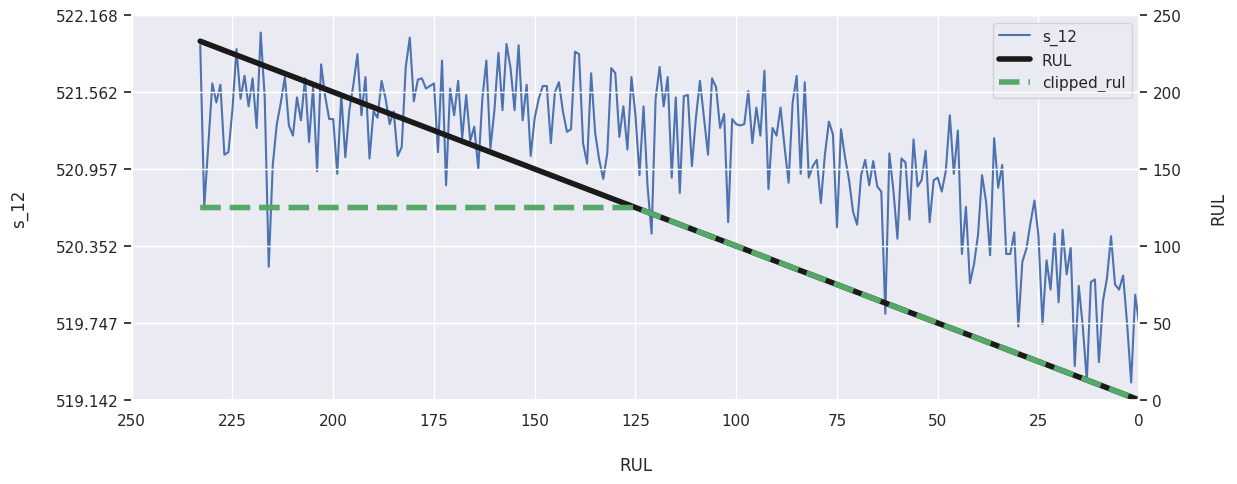

In [5]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 's_12', 'b',
                 data=train.loc[train['unit_nr']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('s_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train.loc[train['unit_nr']==20])
rul = train.loc[train['unit_nr']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--g', linewidth=4, label='clipped_rul')  # SET LABEL MANUALLY?
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis


# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

Retry the baseline model using clipped_rul

In [6]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [7]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [8]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:44.66819159545435, R2:0.579448652779675
test set RMSE:31.95263302774737, R2:0.4087736807655352


In [9]:
y_train_clipped = y_train.clip(upper=125)

In [10]:
all(y_train.where(y_train <= 125, 125) == y_train_clipped)

True

In [11]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)  

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.491018701514925, R2:0.7340432868050568
test set RMSE:21.900213406890565, R2:0.7222608196546229


# SVR

using clipped RUL

## Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()  # for this specific dataset, the type of scaler does not have any effect
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# SVM regression + clipped RUL + scaled
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:21.57826397506789, R2:0.7318795396979632
test set RMSE:21.580480163289746, R2:0.7303113540952123


current RMSE is already an improvement over the baseline regression with clipped RUL

## Feature Engineering

In [13]:
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 14)
(20631, 120)


In [15]:
# SVM regression + clipped RUL + engineered features
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train_clipped)  

# predict and evaluate
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:19.716789731130856, R2:0.776143678570414
test set RMSE:20.585402508371494, R2:0.7546086882115086


## Feature selection


In [16]:
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold='mean', prefit=True)
select_features.get_support()
feature_names = poly.get_feature_names_out(X_train.columns)

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')
Best features:
 ['s_2' 's_3' 's_4' 's_7' 's_9' 's_11' 's_12' 's_14' 's_15' 's_17' 's_20'
 's_21' 's_4 s_9' 's_4 s_13' 's_4 s_14' 's_7 s_9' 's_7 s_13' 's_7 s_14'
 's_8^2' 's_8 s_11' 's_8 s_12' 's_8 s_13' 's_9^2' 's_9 s_11' 's_9 s_12'
 's_9 s_14' 's_9 s_20' 's_9 s_21' 's_11^2' 's_11 s_13' 's_11 s_14'
 's_12 s_13' 's_12 s_14' 's_13^2' 's_14^2' 's_14 s_20' 's_14 s_21']


(37,)

In [17]:
# SVR regression + clipped RUL + engineered features + selection
svr = SVR(kernel='linear')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped) 

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

train set RMSE:19.74678910148113, R2:0.7754619593165268
test set RMSE:20.55613819605453, R2:0.755305891345072


In [19]:
import joblib
# save the model
joblib.dump(svr, 'model/svr_model.pkl')
# load the model
# svr_loaded = joblib.load('svr_model.pkl')

['model/svr_model.pkl']

In [20]:
# Testing the model
svr_loaded = joblib.load('model/svr_model.pkl')
y_hat_test = svr_loaded.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

test set RMSE:20.55613819605453, R2:0.755305891345072


## Model Comparison

In [21]:
from sklearn.neural_network import MLPRegressor

# Neural Network + clipped RUL + engineered features + selection
mlp = MLPRegressor(hidden_layer_sizes=(100, 50, 25), activation='relu',
                   solver='adam', alpha=0.01, batch_size=32,
                   learning_rate='adaptive', learning_rate_init=0.001,
                   max_iter=500, random_state=42, early_stopping=True,
                   validation_fraction=0.1, n_iter_no_change=20)
mlp.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = mlp.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = mlp.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

# save the model
joblib.dump(mlp, 'model/mlp_model.pkl')

train set RMSE:17.717488733490466, R2:0.8192404366855629
test set RMSE:17.648713628435548, R2:0.8196290601568719


['model/mlp_model.pkl']

## Neural Network (Multi-layer Perceptron)

In [22]:
try:
    import lightgbm as lgb
    
    # LightGBM + clipped RUL + engineered features + selection
    lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=6,
                                  num_leaves=31, min_child_samples=20, subsample=0.8,
                                  colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1,
                                  random_state=42, verbose=-1)
    lgb_model.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)
    
    # predict and evaluate
    y_hat_train = lgb_model.predict(X_train_transformed[:, select_features.get_support()])
    evaluate(y_train_clipped, y_hat_train, 'train')
    
    y_hat_test = lgb_model.predict(X_test_transformed[:, select_features.get_support()])
    evaluate(y_test, y_hat_test)
    
    # save the model
    joblib.dump(lgb_model, 'model/lgb_model.pkl')
except ImportError:
    print("LightGBM not installed. Install with: pip install lightgbm")

train set RMSE:14.355819078156719, R2:0.8813267309779491
test set RMSE:18.43926707809845, R2:0.8031081383461465


/home/agspades/projects/pulse-reader/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/agspades/projects/pulse-reader/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## LightGBM Regressor

In [23]:
try:
    import xgboost as xgb
    
    # XGBoost + clipped RUL + engineered features + selection
    xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6,
                                 min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
                                 gamma=0, reg_alpha=0.1, reg_lambda=1, random_state=42)
    xgb_model.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)
    
    # predict and evaluate
    y_hat_train = xgb_model.predict(X_train_transformed[:, select_features.get_support()])
    evaluate(y_train_clipped, y_hat_train, 'train')
    
    y_hat_test = xgb_model.predict(X_test_transformed[:, select_features.get_support()])
    evaluate(y_test, y_hat_test)
    
    # save the model
    joblib.dump(xgb_model, 'model/xgb_model.pkl')
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")

train set RMSE:12.20893610137833, R2:0.9141673445701599
test set RMSE:18.726047526294256, R2:0.7969360947608948


## XGBoost Regressor

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting + clipped RUL + engineered features + selection
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                               min_samples_split=5, min_samples_leaf=2, 
                               subsample=0.8, random_state=42)
gb.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = gb.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = gb.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

# save the model
joblib.dump(gb, 'model/gb_model.pkl')

train set RMSE:14.302779555511796, R2:0.8822020200571202
test set RMSE:18.300695048383012, R2:0.8060563233877586


['model/gb_model.pkl']

## Gradient Boosting Regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest + clipped RUL + engineered features + selection
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                           min_samples_leaf=2, random_state=42, n_jobs=-1)
rf.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

# save the model
joblib.dump(rf, 'model/rf_model.pkl')

train set RMSE:8.978757476372513, R2:0.9535774027090889
test set RMSE:18.388202504653588, R2:0.8041971487875237


['model/rf_model.pkl']